<a href="https://colab.research.google.com/github/epadam/Machine-Learning-Tutorial-Demo-Resources/blob/master/notebooks/nlp/SST_5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are using RNN for SST-5 dataset  sentiment analysis in the notebook.

First download the dataset and unzip the file.

In [ ]:
!wget "https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip"
!unzip /content/stanfordSentimentTreebank.zip 

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Data Preprocessing

In [3]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')

In [4]:
with open('/content/stanfordSentimentTreebank/datasetSentences.txt') as f:
  data=f.readlines()
  data = data[1:]
  for i in range(len(data)):
     _, data[i]= data[i].split('\t') 

In [5]:
with open('/content/stanfordSentimentTreebank/datasetSplit.txt') as t:
  sep = t.readlines()
sep = sep [1:]
for i in range(len(sep)):
  _, sep[i]= sep[i].split(',') 

for i in sep:
  i = int(i)

In [6]:
with open('/content/stanfordSentimentTreebank/sentiment_labels.txt') as l:
  labels = l.readlines()
labels = labels [1:]

In [7]:
len(sep)


11855

In [ ]:
train =[]
train_label =[]
test = []
test_label =[]
dev =[]
dev_label =[]
j,k,l = 0,0,0

for i in range(len(data)):
  if sep[i] == '1':
    train.append(data[i])
    train_label.append(labels[i])
  elif sep[i]=='2':
    test.append(data[i])
    test_label.append(labels[i])
  elif sep[i]=='3':
    dev.append(data[i])
    dev_label.append(labels[i])

In [ ]:
train_label[1]

'0.5\n'

Explore Data Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
lang =[]
for k in range(len(train)):
  lang.append(len(train[k]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


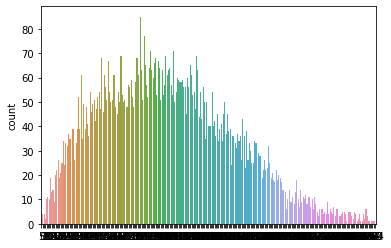

In [ ]:
sns.countplot(lang)

In [ ]:
sns.countplot(sentiment)

Vectorize the text

Build the model

In [17]:
!pip install transformers

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('sst')
dataset

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})

In [4]:
train = dataset["train"]
validation = dataset["validation"]
test = dataset["test"]

train = train.map(lambda examples: {'labels': examples['label']}, batched=True)
validation = validation.map(lambda examples: {'labels': examples['label']}, batched=True)
test = test.map(lambda examples: {'labels': examples['label']}, batched=True)

train

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-120d3956b10f0239.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-532a29a93bf38d5e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-88a21132643bfa22.arrow


Dataset({
    features: ['label', 'labels', 'sentence', 'tokens', 'tree'],
    num_rows: 8544
})

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


In [5]:
import re
train_text = train['sentence']
train_text = list(map(lambda e: e.lower(), train_text))
train_text = list(map(lambda x: re.sub('[^a-zA-z0-9\s]','',x), train_text))

train_labels =  train['labels']

In [10]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train_text)
X = tokenizer.texts_to_sequences(train_text)
X = pad_sequences(X)

In [100]:
train_text[3]

'you d think by now america would have had enough of plucky british eccentrics with hearts of gold '

In [11]:
Y = np.array(train_labels)
Y = np.reshape(Y, (-1, 1))

In [12]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(max_fatures, input_length = X.shape[1], output_dim=128))

model.add(SpatialDropout1D(0.4))
# Add a LSTM layer with 128 internal units.
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 44, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 44, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 1)                 197       
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])

In [75]:
len(train_labels)

8544

In [14]:
batch_size = 32
model.fit(X, Y, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
267/267 - 65s - loss: 0.0618 - accuracy: 0.0030
Epoch 2/2
267/267 - 63s - loss: 0.0409 - accuracy: 0.0036


In [16]:
twt = ['I hate this movie']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]

print(sentiment)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  38 994  16  17]]
1/1 - 0s
[0.48366693]


Bert for SST-5

In [18]:
import torch
from transformers import AutoTokenizer, AutoModel

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
embedding = AutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
X = tokenizer.encode(train_text)
X = pad_sequences(X)

TypeError: ignored

In [23]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [24]:
classifier('We are very happy to show you the 🤗 Transformers library.')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [26]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = train.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

In [32]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train)

In [33]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tree, sentence, tokens.
***** Running training *****
  Num examples = 8544
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3204


ValueError: ignored